In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from scipy.linalg import sqrtm

2022-09-29 19:51:11.761932: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import image
from skimage.transform import resize
import numpy as np
import time
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'

In [3]:
import tensorflow.keras.applications.inception_v3 as pretrained_models
preprocess = tf.keras.applications.inception_v3.preprocess_input

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = '0'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


2022-09-27 09:23:25.443620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 09:23:35.454830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46711 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:98:00.0, compute capability: 8.6


In [3]:
if tf.config.list_physical_devices('GPU'):
  # Returns a dict in the form {'current': <current mem usage>,
  #                             'peak': <peak mem usage>}
    info = tf.config.experimental.get_memory_info('GPU:0')
print(info)

{'current': 0, 'peak': 0}


2022-09-28 14:54:52.509520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 14:54:53.238650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46711 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:98:00.0, compute capability: 8.6


In [4]:
imgs_names = []
folder = "bitmojis/"
for filename in os.listdir(folder):
        imgs_names.append(filename)        

In [5]:
tot_imgs = []
for name in imgs_names:
    cur = image.imread(folder+name)
    tot_imgs.append(cur)


In [6]:
tot_imgs = np.array(tot_imgs)
tot_imgs = (tot_imgs-0.5)*2

In [28]:
tot_imgs.shape

(130227, 128, 128, 3)

In [10]:
noise_dim = 101
latent_dim = 101
BATCH_SIZE = 256

In [45]:
class generator(keras.Model):
    def __init__(self):
        super(generator,self).__init__()
        self.noise_dense = layers.Dense(512*4*4)
        self.bn0l = layers.BatchNormalization()
        self.bn0n = layers.BatchNormalization()

        self.conv1 = layers.Conv2DTranspose(256,5,(3,3))
        self.bn1 = layers.BatchNormalization()
        self.lkre1 = layers.LeakyReLU()
        self.drp1 = layers.Dropout(0.3)

        self.conv2 = layers.Conv2DTranspose(128,4,(2,2))
        self.bn2 = layers.BatchNormalization()
        self.lkre2 = layers.LeakyReLU()
        self.drp2 = layers.Dropout(0.3)

        self.conv3 = layers.Conv2DTranspose(64,4,(2,2))
        self.bn3 = layers.BatchNormalization()
        self.lkre3 = layers.LeakyReLU()
        self.drp3 = layers.Dropout(0.3)

        self.conv4 = layers.Conv2DTranspose(3,6,(2,2),activation = "tanh")



    def call(self,noise):
        
        nse = self.noise_dense(noise)
        nse = self.bn0n(nse)
#         print(512*4*4, nse.shape)
        inp_gen = layers.Reshape((4,4,512))(nse)

        x = self.conv1(inp_gen)
        x = self.bn1(x)
        x = self.lkre1(x)
        x = self.drp1(x)

#         print(x.shape)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lkre2(x)
        x = self.drp1(x)

#         print(x.shape)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lkre3(x)
        x = self.drp1(x)

        # print(x.shape)

        x = self.conv4(x)
        
        return x

gen = generator()



In [46]:
class discriminator(keras.Model):
    def __init__(self):
        super(discriminator,self).__init__()
        self.lat_dense = layers.Dense(128*128*1)

        self.conv1 = layers.Conv2D(64,5,(2,2))
        self.bn1 = layers.BatchNormalization()
        self.lkrl1 = layers.LeakyReLU()
        self.drop1 = layers.Dropout(0.3)

        self.conv2 = layers.Conv2D(128,5,(2,2))
        self.bn2 = layers.BatchNormalization()
        self.lkrl2 = layers.LeakyReLU()
        self.drop2 = layers.Dropout(0.3)

        self.conv3 = layers.Conv2D(256,5,(2,2))
        self.bn3 = layers.BatchNormalization()
        self.lkrl3 = layers.LeakyReLU()
        self.drop3 = layers.Dropout(0.3)

        self.out = layers.Dense(1)




    def call(self,img,latent):
        lat_den = self.lat_dense(latent)
        lat = layers.Reshape((128,128,1))(lat_den)
        disc_inp = layers.Concatenate()([img,lat])
        x = self.conv1(disc_inp)
        x = self.bn1(x)
        x = self.lkrl1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lkrl2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lkrl3(x)
        x = self.drop3(x)

        x = layers.Flatten()(x)

        x = self.out(x)

        return x

disc = discriminator() 



In [47]:

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
encoder = keras.Model(encoder_inputs, z_mean, name="encoder")
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_50 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 re_lu_8 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_51 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                          

In [48]:
def noisy_true_labels(y):
    return y - np.random.random(y.shape) * 0.1

def noisy_false_labels(y):
    return y + np.random.random(y.shape) * 0.1

In [37]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_labels = noisy_true_labels(tf.ones_like(real_output))
    fake_labels = noisy_false_labels(tf.zeros_like(fake_output))
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    fake_labels = noisy_true_labels(tf.ones_like(fake_output))
    return cross_entropy(fake_labels, fake_output)

def encoder_loss(fake_output):
    fake_labels = noisy_false_labels(tf.zeros_like(fake_output))
    return cross_entropy(fake_labels, fake_output)


generator_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
encoder_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [52]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape, tf.GradientTape() as encoder_tape:
        generated_images = gen(noise, training=True)
        enc_latents = encoder(images)
        
        real_output = disc(images,noise, training=True)
        fake_output = disc(generated_images,noise, training=True)
        enc_disc_output = disc(images,enc_latents)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        enc_loss = encoder_loss(enc_disc_output)
        

    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
         
    gradients_of_encoder = encoder_tape.gradient(enc_loss, encoder.trainable_variables)
    encoder_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
    
    return gen_loss,disc_loss,enc_loss

In [53]:
def train(dataset, epochs):
    batches = dataset.shape[0]//BATCH_SIZE
    
    gen_losses = []
    disc_losses = []
    enc_losses = []
    for epoch in range(epochs):
        start = time.time()
        cur = 0
        tot_gen_ls = 0
        tot_disc_ls = 0
        tot_enc_ls = 0
        for x in range(batches):
            gen_ls,disc_ls,enc_ls = train_step(dataset[cur:cur+BATCH_SIZE])
            tot_gen_ls += gen_ls
            tot_disc_ls += disc_ls
            tot_enc_ls += enc_ls
            cur += BATCH_SIZE
        
        gen_losses.append(tot_gen_ls/batches)
        disc_losses.append(tot_disc_ls/batches)
        enc_losses.append(tot_enc_ls/batches)
    
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(gen_losses[-1],disc_losses[-1])
    return gen_losses,disc_losses,enc_losses


In [55]:
gen_losses,disc_losses,enc_losses = train(tot_imgs, 50)


Time for epoch 1 is 106.63111639022827 sec
tf.Tensor(2.8990464, shape=(), dtype=float32) tf.Tensor(0.7260783, shape=(), dtype=float32)
Time for epoch 2 is 106.96724677085876 sec
tf.Tensor(2.7847712, shape=(), dtype=float32) tf.Tensor(0.6133158, shape=(), dtype=float32)
Time for epoch 3 is 106.86532306671143 sec
tf.Tensor(2.8475537, shape=(), dtype=float32) tf.Tensor(0.5899485, shape=(), dtype=float32)
Time for epoch 4 is 106.47166562080383 sec
tf.Tensor(2.8869283, shape=(), dtype=float32) tf.Tensor(0.5537336, shape=(), dtype=float32)
Time for epoch 5 is 106.48908638954163 sec
tf.Tensor(2.9404712, shape=(), dtype=float32) tf.Tensor(0.53618777, shape=(), dtype=float32)
Time for epoch 6 is 106.4495735168457 sec
tf.Tensor(2.9399786, shape=(), dtype=float32) tf.Tensor(0.5671102, shape=(), dtype=float32)
Time for epoch 7 is 106.47336888313293 sec
tf.Tensor(2.9165225, shape=(), dtype=float32) tf.Tensor(0.55925584, shape=(), dtype=float32)
Time for epoch 8 is 106.48817157745361 sec
tf.Tensor(2

In [56]:
gen.save("bi_gan_generator")
disc.save("bi_gan_discriminator")
encoder.save("bi_gan_encoder")

INFO:tensorflow:Assets written to: bi_gan_generator/assets


INFO:tensorflow:Assets written to: bi_gan_generator/assets


INFO:tensorflow:Assets written to: bi_gan_discriminator/assets


INFO:tensorflow:Assets written to: bi_gan_discriminator/assets


INFO:tensorflow:Assets written to: bi_gan_encoder/assets


INFO:tensorflow:Assets written to: bi_gan_encoder/assets


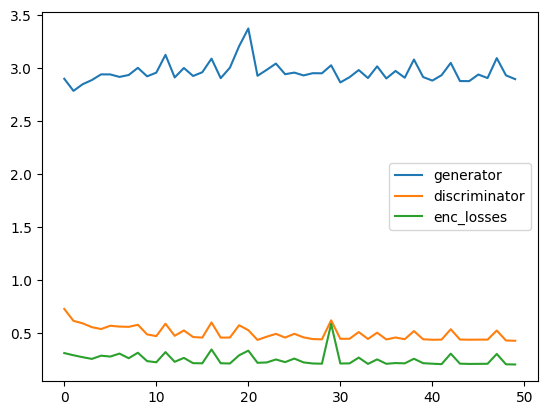

In [57]:
plt.plot(gen_losses)
plt.plot(disc_losses)
plt.plot(enc_losses)
plt.legend(["generator","discriminator","enc_losses"])

In [62]:
def image_generate(n):
    noise = tf.random.normal(shape = (n*n,noise_dim))
    dt = gen(noise)
    imgs = (dt+1)/2
    fig,ax = plt.subplots(n,n)
    cur = 0
    if(n==1):
        ax.imshow(imgs[0])
        return
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(imgs[cur])
            ax[i,j].axis('off')
            cur += 1

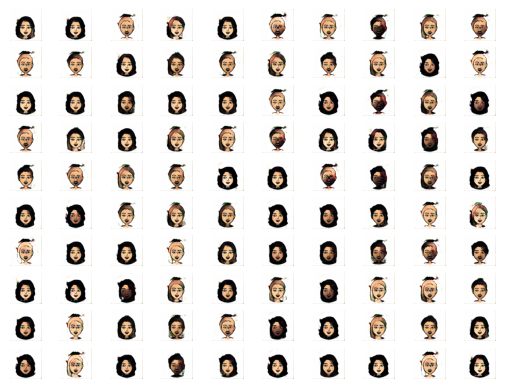

In [67]:
image_generate(10)

In [68]:
inception = pretrained_models.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [69]:
def scale_for_incept(imgs):
    tot = []
    for img in imgs:
        tot.append(resize(img,(299,299,3)))
        
    return np.array(tot)

In [70]:
def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    print("generated_features done")
    act2 = model.predict(images2)
    print("calculating")
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [73]:
def overall_fids(model):
    all_fids = []
    for i in range(20):
        noise = tf.random.normal(shape = (1000,noise_dim))
        generated_imgs = gen(noise,training = False)
        real_indices = random.sample(range(120000),1000)
        real_imgs = []
        for x in real_indices:
            real_imgs.append(tot_imgs[x])
        rl = (np.array(real_imgs)+1)/2
        gn = (generated_imgs+1)/2
        generated_imgs = scale_for_incept(rl)
        real_imgs = scale_for_incept(gn)
        gener_preproce = preprocess(generated_imgs)
        real_preproce = preprocess(real_imgs)
        cur_fid = calculate_fid(inception,generated_imgs,real_imgs)
        all_fids .append(cur_fid)
            
    return all_fids

In [74]:
all_fids = overall_fids(inception)

32/32 [==============================] - 3s 44ms/step
generated_features done
32/32 [==============================] - 1s 32ms/step
calculating
32/32 [==============================] - 1s 33ms/step
generated_features done
32/32 [==============================] - 1s 32ms/step
calculating
32/32 [==============================] - 1s 32ms/step
generated_features done
32/32 [==============================] - 1s 32ms/step
calculating
32/32 [==============================] - 1s 32ms/step
generated_features done
32/32 [==============================] - 1s 33ms/step
calculating
32/32 [==============================] - 1s 32ms/step
generated_features done
32/32 [==============================] - 1s 32ms/step
calculating
32/32 [==============================] - 1s 33ms/step
generated_features done
32/32 [==============================] - 1s 32ms/step
calculating
32/32 [==============================] - 1s 32ms/step
generated_features done
32/32 [==============================] - 1s 32ms/step
calc

In [75]:
min_fids = min(all_fids)
max_fids = max(all_fids)
avg_fids = sum(all_fids)/len(all_fids)
print(min_fids,max_fids,avg_fids)

9.2465855397498 10.538500922443294 9.943667057051435
